In [1]:
import numpy as np
import pandas as pd
import torch
import time
import os
import ast
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
!nvidia-smi
if torch.cuda.is_available():
  print('CUDA is available')
else:
  print('CUDA is not available')

Fri Mar 21 20:34:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
class SlurDataset(Dataset):
    def __init__(self, csv_file, tensor_dir, target_size=(160, 200), device="cuda"):
        self.data = pd.read_csv(csv_file)
        self.tensor_dir = tensor_dir
        self.target_size = target_size  # Fixed target size (H, W)
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the tensor
        crop_file = self.data.iloc[idx]["Crop File Name"]
        tensor_file = os.path.join(self.tensor_dir, crop_file.replace(".png", ".pt"))
        tensor = torch.load(tensor_file, map_location=self.device)  # Load directly on GPU
        tensor = tensor.to(torch.float32)   # Convert to float32

        # Original size
        _, original_h, original_w = tensor.shape

        # Resize tensor
        tensor = F.interpolate(tensor.unsqueeze(0), size=self.target_size, mode="bilinear", align_corners=False)
        tensor = tensor.squeeze(0)

        # Adjust control points
        scale_w = self.target_size[1] / original_w
        scale_h = self.target_size[0] / original_h

        control_points = []
        for i in range(5):
            key = f"P{i}"
            x, y = ast.literal_eval(self.data.iloc[idx][key])  # Convert string to list
            x_new = x * scale_w  # Scale x
            y_new = y * scale_h  # Scale y
            control_points.extend([x_new, y_new])  # Flatten to 10D vector

        target = torch.tensor(control_points, dtype=torch.float32)

        return tensor, target


In [4]:
train_val_csv = "/content/drive/MyDrive/ESC499/Slur_Generation/data/train_val.csv"
train_val_tensor = "/content/drive/MyDrive/ESC499/Slur_Generation/data/train_val"
test_csv = "/content/drive/MyDrive/ESC499/Slur_Generation/data/test.csv"
test_tensor = "/content/drive/MyDrive/ESC499/Slur_Generation/data/test"

train_val_data = SlurDataset(csv_file = train_val_csv, tensor_dir = train_val_tensor)
test_dataset = SlurDataset(csv_file = test_csv, tensor_dir = test_tensor)

train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size

torch.manual_seed(1000)
train_dataset, val_dataset = random_split(train_val_data, [train_size, val_size])

print(f"Training: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Testing: {len(test_dataset)}")

Training: 2022
Validation: 506
Testing: 560


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model = SlurCNN()
model.cuda()
for imgs, labels in train_loader:
    print(f"Before passing to model: dtype={imgs.dtype}, shape={imgs.shape}")
    imgs, labels = imgs.cuda(), labels.cuda()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0002)

    optimizer.zero_grad()
    out = model(imgs)  # Forward pass
    loss = criterion(out, labels)  # Compute loss
    loss.backward()
    optimizer.step()

Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing to model: dtype=torch.float32, shape=torch.Size([32, 4, 160, 200])
Before passing t

KeyboardInterrupt: 

In [5]:
class SlurCNN(nn.Module):
    def __init__(self, input_size=(160, 200)):  # Tensor target size
        super(SlurCNN, self).__init__()
        self.name = "SlurCNN"

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 20 * 25, 512)
        self.fc2 = nn.Linear(512, 10)  # 5 control points x 2 coordinates

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)  # Flattening

        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for regression task

        return x


In [21]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """Generates a filename for saving the model."""
    path = "model_{0}_bs{1}_lr{2}_epoch{3}.pth".format(name, batch_size, learning_rate, epoch)
    return path

def get_accuracy(model, data_loader, threshold=15):
    """
    Computes accuracy: A prediction is correct if all five control points
    are within threshold pixels of the actual points.
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            output = model(imgs)  # Get predictions
            diff = torch.abs(output - labels)  # Absolute difference

            diff = diff.view(-1, 5, 2)  # Reshape to compare (5,2) pairs
            # Check if all five points are within the threshold
            correct_predictions = (diff <= threshold).all(dim=(1, 2))  # True if all (x,y) pairs are within 30 pixels

            correct += correct_predictions.sum().item()
            total += labels.shape[0]

    model.train()  # Set model back to training mode
    return round(correct / total, 3)

In [13]:
def train(model, train_dataset, val_dataset, batch_size=32, learning_rate=0.0002, num_epochs=20):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    # start_time = time.time()
    n = 0
    for epoch in range(num_epochs):

        start_epoch_time = time.time()
        epoch_loss = 0

        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)    # Forward pass
            loss = criterion(out, labels)    # Compute loss
            loss.backward()      # Back propagation
            optimizer.step()     # Update weights

            epoch_loss += loss.item()     # Accumulate loss
            iters.append(n)
            losses.append(loss.item())    # Save loss
            n += 1

        # Compute accuracy
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))

        print(f"Epoch {epoch + 1}: Train Loss: {epoch_loss / len(train_loader):.4f} | Train Acc: {train_acc[-1]} | Val Acc: {val_acc[-1]}")
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        end_epoch_time = time.time()
        print(f"Epoch {epoch + 1} took {end_epoch_time - start_epoch_time:.2f} seconds")

    # end_time = time.time()
    # print(f"Total training time: {end_time - start_time:.2f} seconds")

    plt.figure()
    plt.plot(iters, losses, label="Train Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

    plt.figure()
    epochs = np.arange(0, num_epochs)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

Epoch 1: Train Loss: 1297.7515 | Train Acc: 0.304 | Val Acc: 0.291
Epoch 1 took 19.34 seconds
Epoch 2: Train Loss: 122.0354 | Train Acc: 0.366 | Val Acc: 0.354
Epoch 2 took 19.44 seconds
Epoch 3: Train Loss: 106.9865 | Train Acc: 0.491 | Val Acc: 0.514
Epoch 3 took 19.32 seconds
Epoch 4: Train Loss: 89.8049 | Train Acc: 0.574 | Val Acc: 0.597
Epoch 4 took 19.19 seconds
Epoch 5: Train Loss: 67.0151 | Train Acc: 0.733 | Val Acc: 0.729
Epoch 5 took 19.26 seconds
Epoch 6: Train Loss: 52.0174 | Train Acc: 0.79 | Val Acc: 0.781
Epoch 6 took 19.15 seconds
Epoch 7: Train Loss: 45.6408 | Train Acc: 0.816 | Val Acc: 0.808
Epoch 7 took 19.57 seconds
Epoch 8: Train Loss: 40.2551 | Train Acc: 0.834 | Val Acc: 0.832
Epoch 8 took 19.42 seconds
Epoch 9: Train Loss: 36.4306 | Train Acc: 0.865 | Val Acc: 0.874
Epoch 9 took 19.13 seconds
Epoch 10: Train Loss: 33.2741 | Train Acc: 0.847 | Val Acc: 0.846
Epoch 10 took 19.28 seconds
Epoch 11: Train Loss: 32.2039 | Train Acc: 0.887 | Val Acc: 0.885
Epoch 11 

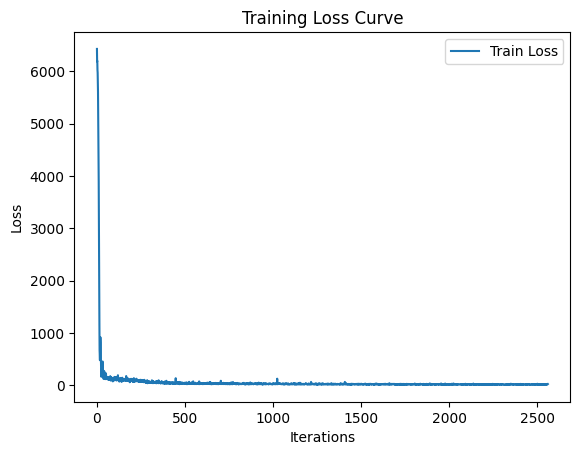

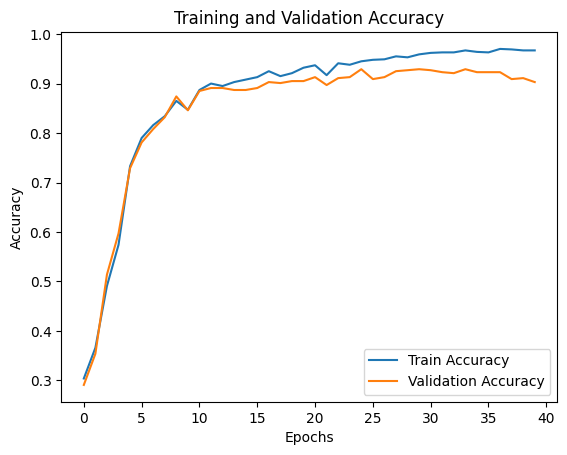

In [22]:
model = SlurCNN()
model.cuda()
train(model, train_dataset, val_dataset, batch_size=32, learning_rate=0.0002, num_epochs=40)

In [23]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)
print(get_accuracy(model, test_loader))

0.866


In [27]:
def export_predictions(model_path, test_dataset, csv_output_path="predictions.csv"):
    """
    Generates predictions on the test dataset and saves them to a CSV file.
    The control points are mapped back to their original image sizes.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize model
    model = SlurCNN().to(device)
    model.eval()  # Set model to evaluation mode

    # Load model weights
    state = torch.load(model_path)
    model.load_state_dict(state)

    predictions_list = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for idx in range(len(test_dataset)):
            # Load data
            tensor, target = test_dataset[idx]  # Get single test sample
            tensor = tensor.unsqueeze(0).to(device)  # Add batch dimension

            # Get original image size (before transformation)
            crop_file = test_dataset.data.iloc[idx]["Crop File Name"]
            tensor_file = os.path.join(test_dataset.tensor_dir, crop_file.replace(".png", ".pt"))
            original_tensor = torch.load(tensor_file)  # Load original for size
            _, original_h, original_w = original_tensor.shape  # Extract original size

            # Get model predictions
            prediction = model(tensor).squeeze(0).cpu().numpy()

            # Get scaling factors (reverse the transformation)
            target_h, target_w = test_dataset.target_size  # Transformed tensor size
            scale_w = original_w / target_w
            scale_h = original_h / target_h

            # Convert predicted control points back to original size
            predicted_points = []
            for i in range(5):
                x_pred = prediction[i * 2] * scale_w  # Reverse width scaling
                y_pred = prediction[i * 2 + 1] * scale_h  # Reverse height scaling
                predicted_points.append(f"[{x_pred:.2f}, {y_pred:.2f}]")

            # Save results
            predictions_list.append([crop_file] + predicted_points)

    # Convert to DataFrame and save to CSV
    columns = ["Crop File Name", "P0", "P1", "P2", "P3", "P4"]
    predictions_df = pd.DataFrame(predictions_list, columns=columns)
    predictions_df.to_csv(csv_output_path, index=False)

    print(f"Predictions saved to {csv_output_path}")


In [28]:
csv_output_path = "/content/drive/MyDrive/ESC499/Slur_Generation/data/test_predictions.csv"
model_path = "model_SlurCNN_bs32_lr0.0002_epoch39.pth"
export_predictions(model_path, test_dataset, csv_output_path)

Predictions saved to /content/drive/MyDrive/ESC499/Slur_Generation/data/test_predictions.csv
